# California Housing Price Prediction - EDA & Preprocessing

## Overview

This notebook performs exploratory data analysis (EDA) and preprocessing on the California housing dataset to prepare clean, engineered features for machine learning model training. The pipeline includes data quality assessment, multivariate outlier detection using Isolation Forest, feature engineering, categorical encoding, stratified train/validation/test splitting, and feature scaling.

## Notebook Workflow (In Order)

This notebook systematically prepares the California housing dataset through the following 12 ordered steps:

1. **Import Libraries & Setup**: Load necessary packages and configure visualization settings
2. **Load & Explore Raw Data**: Inspect dataset shape, data types, and basic statistics
3. **Data Quality Analysis**: Examine missing values, duplicates, feature distributions, outliers, and target variable characteristics
4. **Correlation Analysis**: Identify relationships between features and target; detect multicollinearity
5. **Data Visualizations**: Create distribution plots, correlation heatmap, and target variable analysis
6. **Handle Missing Values**: Impute missing data using median strategy
7. **Feature Engineering**: Create derived features (rooms/household, bedrooms/room, population/household)
8. **Categorical Encoding**: Convert categorical variables to numerical format (one-hot encoding)
9. **Outlier Removal**: Remove multivariate outliers using Isolation Forest for cleaner data
10. **Train/Validation/Test Split**: Create stratified splits (60/20/20) preserving target distribution
11. **Feature Scaling**: Standardize features using StandardScaler fitted on training data only
12. **Save Artifacts**: Export processed datasets and preprocessing objects for model training and deployment

Each section includes detailed analysis insights explaining findings and their implications for model training.

### Import libraries and set default options

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 1. Load and Explore Raw Data

Load the dataset and inspect its shape, data types, and basic statistics.

In [2]:
# Load the raw data
df = pd.read_csv('../data/raw/california-housing.csv')

# Basic data inspection
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nBasic statistics:")
print(df.describe())

Dataset Shape: (20640, 10)

First few rows:
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  

Data types:
longitude         

### Insights:
- The dataset contains 20,640 samples with 10 features (9 features + 1 target variable)
- All features, except ocean_proximity, are numerical
- There seem to be some missing values for the total_bedrooms feature
- median_house_value is the feature that represents house prices in the dataset so it will be the target variable

## 2. Data Analysis

Analyze missing values, duplicates, feature distributions, outliers, and correlations.

In [3]:
# Missing values analysis
print(f"\nTotal missing values: {df.isnull().sum().sum()}")
print("\nMissing values:\n", df.isnull().sum())

# Duplicate values analysis
print(f"\nTotal duplicate rows: {df.duplicated().sum()}")


Total missing values: 207

Missing values:
 longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

Total duplicate rows: 0


### Insights:
- Only the feature total_bedrooms has some missing data that needs to be handled
- No duplicate rows in the dataset

### Numerical features analysis

In [4]:
# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = ["ocean_proximity"]

print("\nStatistics:")
advanced_stats = pd.DataFrame({
    'Column': numerical_cols,
    'Mean': [df[col].mean() for col in numerical_cols],
    'Median': [df[col].median() for col in numerical_cols],
    'Std': [df[col].std() for col in numerical_cols],
    'Skewness': [df[col].skew() for col in numerical_cols],
    'Kurtosis': [df[col].kurtosis() for col in numerical_cols]
}).round(4)
print(advanced_stats.to_string(index=False))

# Outlier detection using Isolation Forest
# Isolation Forest detects outliers by isolating anomalies using random feature/split selection

# Prepare features for Isolation Forest (requires 2D array)
X_numerical = df[numerical_cols].copy()

# Initialize and fit Isolation Forest
# contamination='auto' automatically estimates the proportion of outliers (~5%)
iso_forest = IsolationForest(contamination='auto', random_state=42, n_estimators=100)
outlier_predictions = iso_forest.fit_predict(X_numerical)

# Count outliers
n_outliers = (outlier_predictions == -1).sum()
outlier_pct = (n_outliers / len(df)) * 100

print(f"\nTotal outliers detected: {n_outliers} ({outlier_pct:.2f}%)")
print(f"Total inliers: {len(df) - n_outliers} ({100 - outlier_pct:.2f}%)")

# Analyze outliers per feature using z-score method
print("\nOutliers per feature (extreme values in IF-detected samples):")

# Get indices of samples Isolation Forest flagged as outliers
outlier_indices = np.where(outlier_predictions == -1)[0]
outlier_data = df.iloc[outlier_indices]

outliers_per_feature = pd.DataFrame({
    'Feature': X_numerical.columns,
    'Extreme_Values_in_Outliers': [
        ((np.abs(stats.zscore(df[col])) > 3)).sum() 
        for col in X_numerical.columns
    ],
    'In_IF_Detected_Outliers': [
        ((np.abs(stats.zscore(outlier_data[col])) > 3)).sum() 
        for col in X_numerical.columns
    ]
}).sort_values('Extreme_Values_in_Outliers', ascending=False)

print(outliers_per_feature.to_string(index=False))


Statistics:
            Column        Mean      Median         Std  Skewness  Kurtosis
         longitude   -119.5697   -118.4900      2.0035   -0.2978   -1.3302
          latitude     35.6319     34.2600      2.1360    0.4660   -1.1178
housing_median_age     28.6395     29.0000     12.5856    0.0603   -0.8006
       total_rooms   2635.7631   2127.0000   2181.6153    4.1473   32.6309
    total_bedrooms    537.8706    435.0000    421.3851    3.4595   21.9856
        population   1425.4767   1166.0000   1132.4621    4.9359   73.5531
        households    499.5397    409.0000    382.3298    3.4104   22.0580
     median_income      3.8707      3.5348      1.8998    1.6467    4.9525
median_house_value 206855.8169 179700.0000 115395.6159    0.9778    0.3279

Total outliers detected: 2857 (13.84%)
Total inliers: 17783 (86.16%)

Outliers per feature (extreme values in IF-detected samples):
           Feature  Extreme_Values_in_Outliers  In_IF_Detected_Outliers
       total_rooms              

### Insights:
- Some features show high skewness and very high kurtosis, indicating non-normal distributions
- Isolation Forest detected ~13.84% of samples as outliers based on multivariate anomaly patterns (these outliers represent unusual combinations of feature values)
- total_rooms, population, households and median_income all show high skewness and kurtosis while also having a lot of extreme values
- a lot of data is unusal for this dataset and could be removed

### Target and categorical features analysis

In [5]:
# Target variable analysis
target = "median_house_value"
print(f"\nTarget statistics ($):")
print(df[target].describe().round(2))

# Check for capped values
max_value = df[target].max()
capped_count = (df[target] == max_value).sum()
print(f"\nRows with maximum value (${max_value:,.0f}): {capped_count} ({capped_count/len(df)*100:.2f}%)")

print("\nCategorical features: ")
for col in categorical_cols:
    print(df[col].value_counts())
    print(f"Total unique: {df[col].nunique()}")


Target statistics ($):
count     20640.00
mean     206855.82
std      115395.62
min       14999.00
25%      119600.00
50%      179700.00
75%      264725.00
max      500001.00
Name: median_house_value, dtype: float64

Rows with maximum value ($500,001): 965 (4.68%)

Categorical features: 
ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64
Total unique: 5


### Insights:
- ~4.5% of data is capped and has the maximum value (500.001$), indicating censored data - actual prices might be higher
- This capping limits the model's ability to predict upper price ranges accurately
- The target distribution is right-skewed with a concentration in the $100k-$300k range
- We'll work with the data as-is, but models trained on this data may underestimate high-value properties
- ocean_proximity has 5 unique values, which show as that most properties are close to water

### Correlation analysis

In [6]:
# Correlation analysis
correlations = df[numerical_cols].corr()[target].drop(target).sort_values(ascending=False)
print("\nFeature correlation with target:")
print(correlations)


Feature correlation with target:
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64


### Insights:
- median_income and latitude are the strongest predictors and have the strongest effect on house prices
- total_rooms and housing_median_age show less significant but also noticeable effect


## 3. Data Visualizations

Create visual representations to confirm statistical findings and identify patterns.

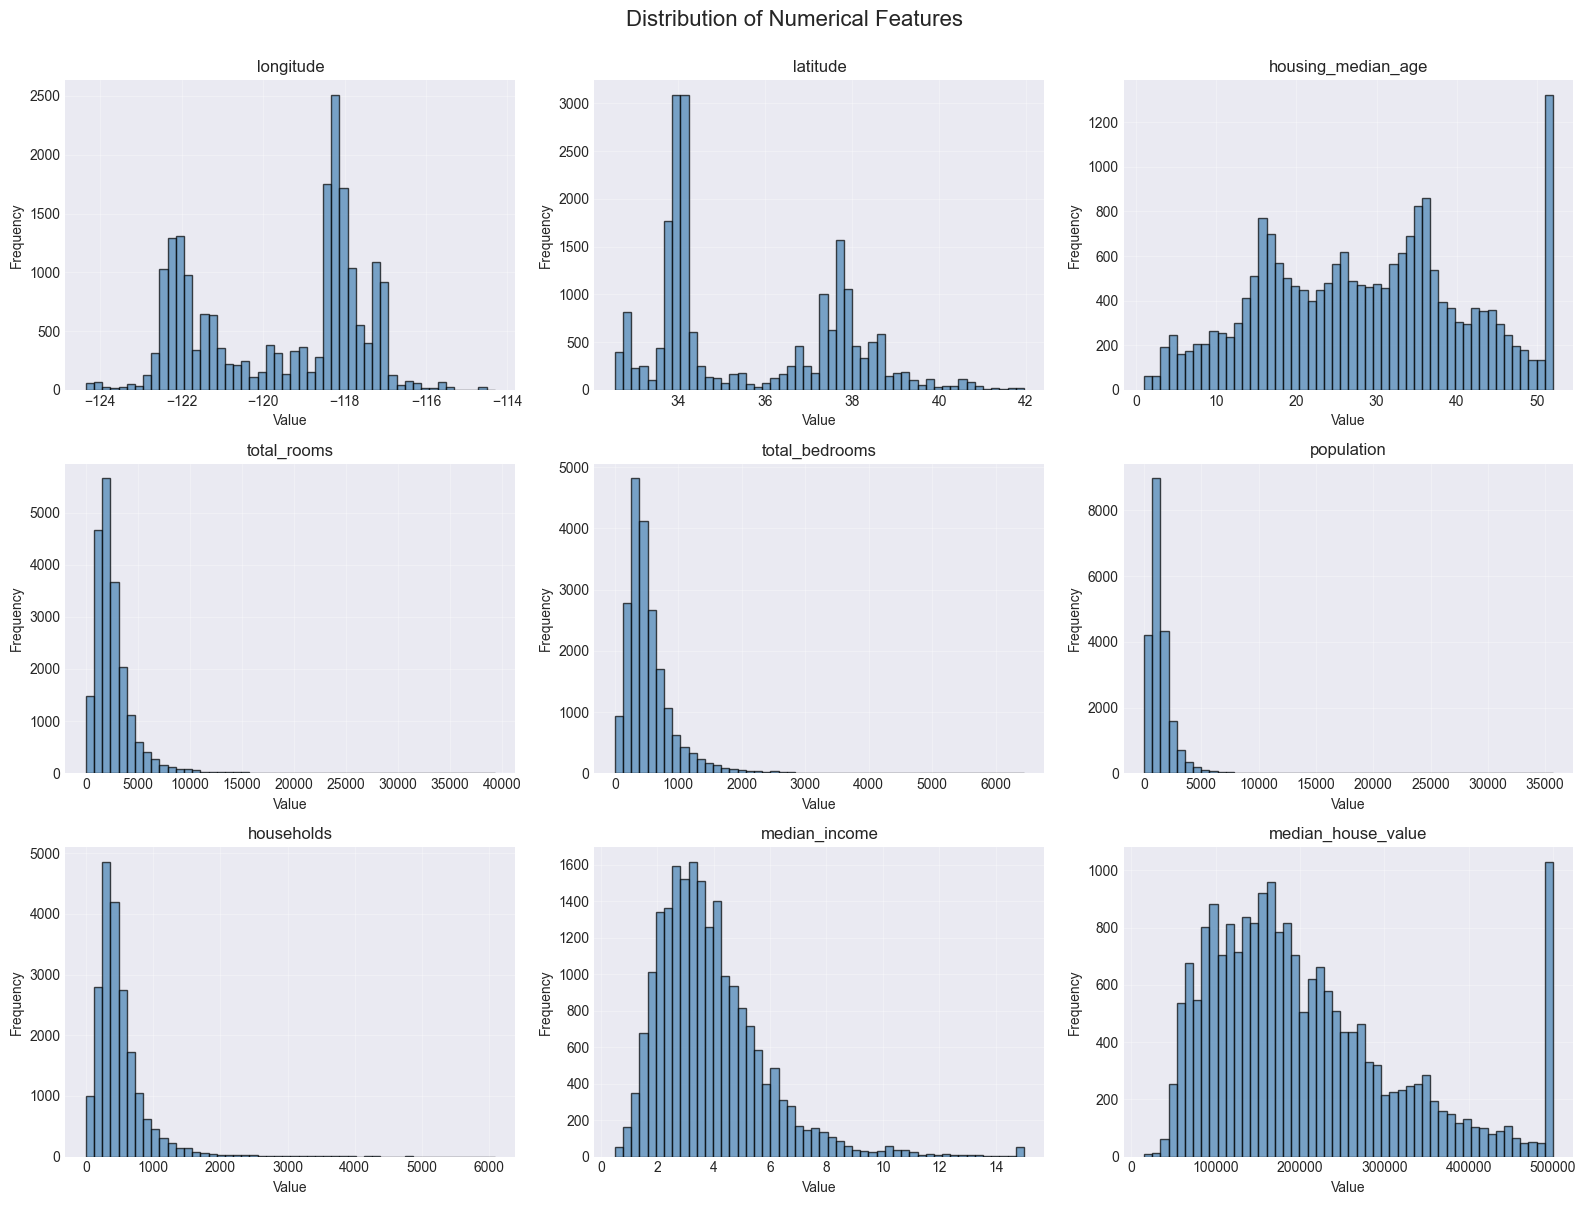

In [7]:
# Visualize distributions of numerical features
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
fig.suptitle('Distribution of Numerical Features', fontsize=16, y=1.00)

for idx, col in enumerate(numerical_cols[:9]):
    row = idx // 3
    col_idx = idx % 3
    ax = axes[row, col_idx]
    
    ax.hist(df[col], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    ax.set_title(f'{col}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Insights:
- Latitude and longitude show bimodal distributions (probably coast vs inland differences)
- total_rooms, total_bedrooms, population and households: All show extreme right skew (another problem for predicting high target values) and could be multicollinear
- housing_median_age is nearly normal, until we cross the 50 year mark (which could also suggest capped values)
- median income is also right skewed, but much less then the other four features (most incomes are between 1 and 6)
- the target variable confirms what we found before, lightly right skewed with most properties valued between 100.000$ and 300.000$ and a lot of properties with capped values

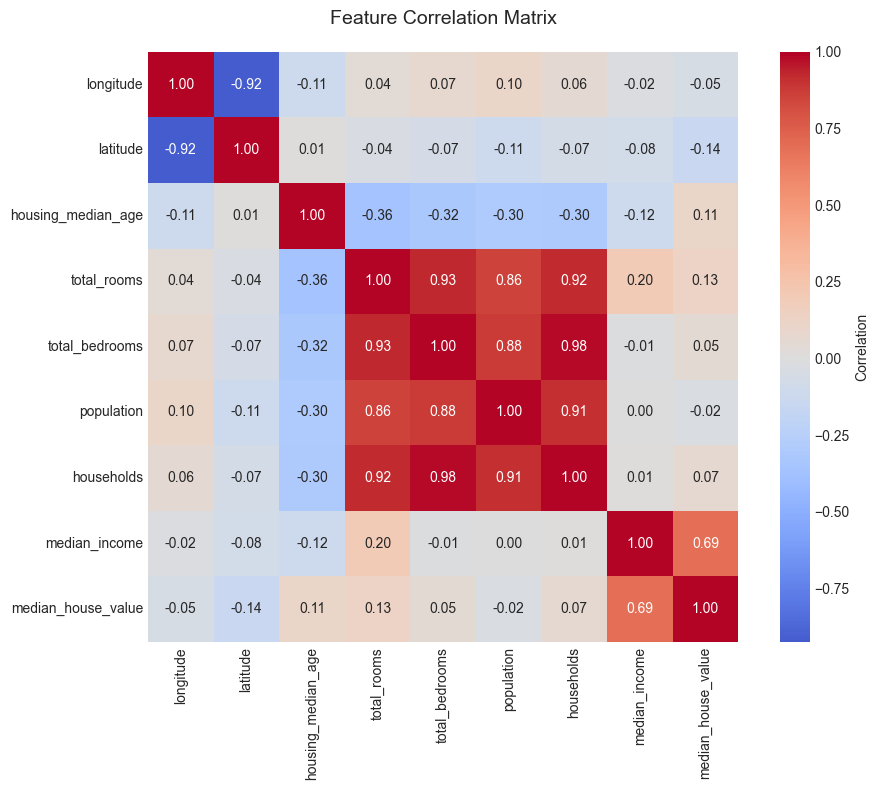

In [8]:
# Correlation heatmap
corr_matrix = df[numerical_cols].corr()
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            cbar_kws={'label': 'Correlation'}, ax=ax, square=True)
ax.set_title('Feature Correlation Matrix', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

### Insights:
- Confirms that total_rooms, total_bedrooms, population and households are highly collinear
- Confirms that the median_income has the highest effect on the target variable
- Confirms that latitude and longitude are highly collinear

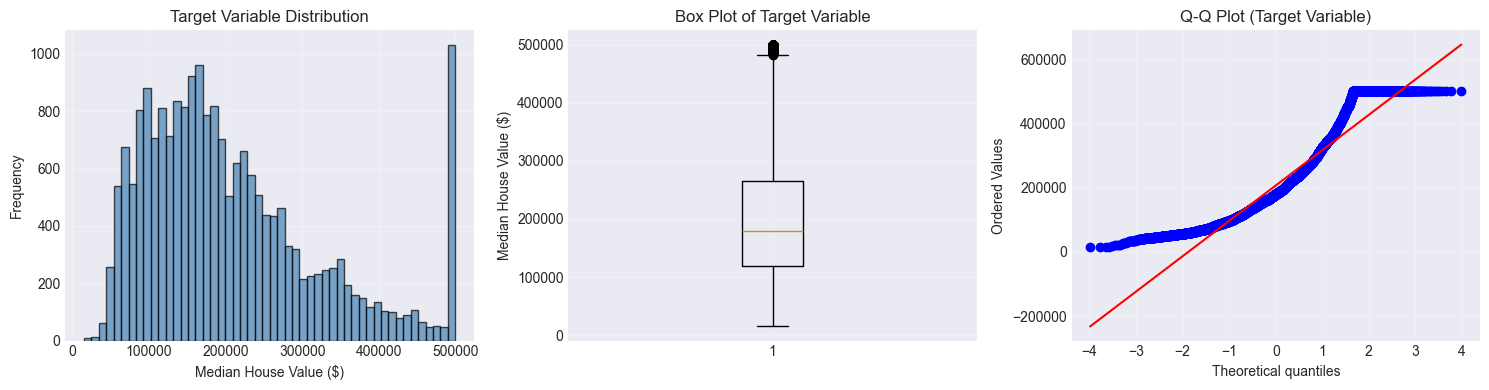

In [9]:
# Target variable distribution analysis
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(df[target], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_title('Target Variable Distribution')
axes[0].set_xlabel('Median House Value ($)')
axes[0].set_ylabel('Frequency')
axes[0].grid(alpha=0.3)

axes[1].boxplot(df[target], vert=True)
axes[1].set_title('Box Plot of Target Variable')
axes[1].set_ylabel('Median House Value ($)')
axes[1].grid(alpha=0.3)

stats.probplot(df[target], dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot (Target Variable)')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Insights:
- Confirmation of right skew with concentration in $100k-$300k range and a capped distribution at $500k
- Box plot clearly shows the capped values as outliers
- Q-Q plot reveals deviation from normality, especially in the tails

## 4. Data Cleaning & Preprocessing

Apply transformations to prepare data for model training: handle missing values, engineer features, scale, and create splits.

### Handling missing values in total_bedrooms

In [10]:
# Create a copy for preprocessing
df_clean = df.copy()

# Impute missing values in total_bedrooms with median
imputer = SimpleImputer(strategy='median')
cols_to_impute = ['total_bedrooms']

print(f"Imputing missing values in {cols_to_impute} using median...")
df_clean[cols_to_impute] = imputer.fit_transform(df_clean[cols_to_impute])

print(f"Imputation complete")
print(f"Remaining missing values: {df_clean.isnull().sum().sum()}")

Imputing missing values in ['total_bedrooms'] using median...
Imputation complete
Remaining missing values: 0


### Insights:
- Successfully imputed missing values in total_bedrooms using the median of the feature
- Median imputation is appropriate here because it's robust to outliers

### Feature Engineering

In [11]:
# Create derived features by combining highly corellated features

# Rooms per household
df_clean['rooms_per_household'] = df_clean['total_rooms'] / df_clean['households']

# Bedrooms per total rooms
df_clean['bedrooms_per_room'] = df_clean['total_bedrooms'] / df_clean['total_rooms']

# Population per househoold
df_clean['population_per_household'] = df_clean['population'] / df_clean['households']

# Check for any NaN/Inf values created by feature engineering
print(f"\nNaN values after feature engineering: {df_clean.isnull().sum().sum()}")
print(f"Inf values: {np.isinf(df_clean.select_dtypes(include=[np.number])).sum().sum()}")

# Drop any rows with NaN or Inf
df_clean = df_clean.dropna()
df_clean = df_clean[~np.isinf(df_clean.select_dtypes(include=[np.number])).any(axis=1)]

# Show changes
print(f"Dataset shape after cleanup: {df_clean.shape}")
print(df_clean[['rooms_per_household', 'bedrooms_per_room', 'population_per_household']].head())
print(df_clean[['rooms_per_household', 'bedrooms_per_room', 'population_per_household']].describe())



NaN values after feature engineering: 0
Inf values: 0
Dataset shape after cleanup: (20640, 13)
   rooms_per_household  bedrooms_per_room  population_per_household
0             6.984127           0.146591                  2.555556
1             6.238137           0.155797                  2.109842
2             8.288136           0.129516                  2.802260
3             5.817352           0.184458                  2.547945
4             6.281853           0.172096                  2.181467
       rooms_per_household  bedrooms_per_room  population_per_household
count         20640.000000       20640.000000              20640.000000
mean              5.429000           0.213794                  3.070655
std               2.474173           0.065248                 10.386050
min               0.846154           0.037151                  0.692308
25%               4.440716           0.175225                  2.429741
50%               5.229129           0.203159                  2

### Insights:
- Features were created successfully
- Created 3 new features capturing domain knowledge:
  - **rooms_per_household**: How much living space is in the household
  - **bedrooms_per_room**: Shows housing type (apartments vs. houses)
  - **population_per_household**: How crowded the housing is
- There was no NaN or infinite values created so the data quality was maintained

In [12]:
# Separate features and target
X = df_clean.drop('median_house_value', axis=1)
y = df_clean['median_house_value']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# One-hot encode categorical variables
print("\nApplying one-hot encoding to categorical features...")

X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print(f"One-hot encoding complete")
print(f"Features after encoding: {X_encoded.shape}")
print(f"New columns from encoding: {X_encoded.columns.tolist()}")

Features shape: (20640, 12)
Target shape: (20640,)

Applying one-hot encoding to categorical features...
One-hot encoding complete
Features after encoding: (20640, 15)
New columns from encoding: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'rooms_per_household', 'bedrooms_per_room', 'population_per_household', 'ocean_proximity_INLAND', 'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN']


### Insights:
- All features are now numerical
- Features and target separated for modeling

### Handling outliers

In [13]:
# Handle outliers using Isolation Forest
print("Removing outliers detected by Isolation Forest...")

# Fit Isolation Forest on the encoded features
iso_forest_treatment = IsolationForest(contamination='auto', random_state=42, n_estimators=100)
iso_forest_treatment.fit(X_encoded)

# Get predictions: -1 for outliers, 1 for inliers
outlier_mask = iso_forest_treatment.predict(X_encoded) == -1

# Get the number and percentage of outliers
n_outliers_removed = outlier_mask.sum()
outlier_removal_pct = (n_outliers_removed / len(X_encoded)) * 100
print(f"Detected and removing {n_outliers_removed} outlier samples ({outlier_removal_pct:.2f}%)")

# Remove outliers from both features and target (by selecting everything not in the mask with ~)
X_treated = X_encoded[~outlier_mask].copy()
y_treated = y[~outlier_mask].copy()

print(f"Outlier removal complete")
print(f"Final feature matrix shape: {X_treated.shape}")
print(f"Final target shape: {y_treated.shape}")

Removing outliers detected by Isolation Forest...
Detected and removing 2221 outlier samples (10.76%)
Outlier removal complete
Final feature matrix shape: (18419, 15)
Final target shape: (18419,)


### Insights:
- Isolation Forest identified and removed multivariate outliers
- Removed samples are those with unusual feature combinations, not just extreme individual values (more robust approach than univariate methods - captures complex outlier patterns)

In [14]:
# Train/Validation/Test splitting (stratified by target percentiles)

# Create price bins for stratified splitting
price_bins = pd.qcut(y_treated, q=10, duplicates='drop')

# First split: 80% train+val, 20% test (stratified by price bins)
X_temp, X_test, y_temp, y_test, bins_temp, bins_test = train_test_split(
    X_treated, y_treated, price_bins,
    test_size=0.2,
    random_state=42,
    stratify=price_bins
)

# Second split: 75% train, 25% validation from the temp set (stratified)
X_train, X_val, y_train, y_val, bins_train, bins_val = train_test_split(
    X_temp, y_temp, bins_temp,
    test_size=0.25,
    random_state=42,
    stratify=bins_temp
)

print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X_treated)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X_treated)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X_treated)*100:.1f}%)")

print(f"\nTarget statistics:")
print(f"  Train - Mean: ${y_train.mean():,.0f}, Std: ${y_train.std():,.0f}")
print(f"  Val   - Mean: ${y_val.mean():,.0f}, Std: ${y_val.std():,.0f}")
print(f"  Test  - Mean: ${y_test.mean():,.0f}, Std: ${y_test.std():,.0f}")

Training set: 11051 samples (60.0%)
Validation set: 3684 samples (20.0%)
Test set: 3684 samples (20.0%)

Target statistics:
  Train - Mean: $203,427, Std: $111,981
  Val   - Mean: $203,625, Std: $113,095
  Test  - Mean: $202,857, Std: $111,933


### Insights:
- **Stratified Split**: Preserves target value distribution across all three sets
- **Balanced Proportions**: Train (60%), Validation (20%), Test (20%)
- **Similar Target Statistics**: Each set has similar mean and std, ensuring representative samples

In [15]:
# Feature Scaling (fit on training data only to avoid data leakage)

# Fit scaler on training data
scaler = StandardScaler()
scaler.fit(X_train)

# Transform all sets
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames to preserve column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Feature scaling complete (StandardScaler)")
print(f"\nScaled training set statistics:")
print(f"  Mean: {X_train_scaled.mean().mean():.6f}")
print(f"  Std: {X_train_scaled.std().mean():.6f}")

print(f"\nScaled validation set statistics:")
print(f"  Mean: {X_val_scaled.mean().mean():.6f}")
print(f"  Std: {X_val_scaled.std().mean():.6f}")

print(f"\nScaled test set statistics:")
print(f"  Mean: {X_test_scaled.mean().mean():.6f}")
print(f"  Std: {X_test_scaled.std().mean():.6f}")

Feature scaling complete (StandardScaler)

Scaled training set statistics:
  Mean: 0.000000
  Std: 1.000045

Scaled validation set statistics:
  Mean: 0.003130
  Std: 0.938016

Scaled test set statistics:
  Mean: -0.008686
  Std: 0.942188


### Insights:
- **StandardScaler Applied**: All features now have mean ≈ 0 and std ≈ 1
- **Fit on Training Data Only**: Crucial for preventing data leakage - validation/test use training statistics
- Scaling prevents features with large scales (e.g., longitude, price) from dominating algorithms
- Scaled data is consistent across all sets, ensuring fair model evaluation

## 5. Save Processed Data & Artifacts

Export cleaned, engineered, and scaled datasets along with preprocessing objects for reproducibility.

In [16]:
# Save scaled datasets
X_train_scaled.to_csv('../data/processed/X_train.csv', index=False)
X_val_scaled.to_csv('../data/processed/X_val.csv', index=False)
X_test_scaled.to_csv('../data/processed/X_test.csv', index=False)
y_train.to_csv('../data/processed/y_train.csv', index=False, header=['target'])
y_val.to_csv('../data/processed/y_val.csv', index=False, header=['target'])
y_test.to_csv('../data/processed/y_test.csv', index=False, header=['target'])

print("Datasets saved:")
print("  - X_train.csv, X_val.csv, X_test.csv")
print("  - y_train.csv, y_val.csv, y_test.csv")

print(f"\nSummary:")
print(f"  Original dataset: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"  Dataset after preprocessing: {X_train_scaled.shape[0] + X_val_scaled.shape[0] + X_test_scaled.shape[0]} rows × {X_train_scaled.shape[1]} columns")
print(f"  Train/Val/Test: {X_train_scaled.shape[0]}/{X_val_scaled.shape[0]}/{X_test_scaled.shape[0]} rows")

Datasets saved:
  - X_train.csv, X_val.csv, X_test.csv
  - y_train.csv, y_val.csv, y_test.csv

Summary:
  Original dataset: 20640 rows × 10 columns
  Dataset after preprocessing: 18419 rows × 15 columns
  Train/Val/Test: 11051/3684/3684 rows


### Preprocessing complete

**Data Transformation Summary:**
- Original dataset: 20,640 samples × 10 features
- After preprocessing: 18,419 samples × 15 features (+ target)

**Features in Final Dataset:**
- Original numerical features: 8 (without target)
- Engineered ratio features: 3 (rooms_per_household, bedrooms_per_room, population_per_household)
- Categorical (one-hot encoded): 4 (ocean_proximity categories, drop_first=True)
- **Total: 15 features**

**Key Limitations & Considerations for Model Training:**

1. **Target Variable Capping**: ~4.5% of data capped at $500k
   - Models will struggle to predict high-value properties accurately
   - This needs to be considered when evaluating model performance on upper price ranges

2. **Feature Collinearity and skewness**: Original + engineered features not handled
   - **For tree-based models**: Data is safe for training
   - **For linear models**: Data needs a bit more processing (VIF analysis, potential feature dropping, log transformations...)

**Data Quality Summary:**
- No missing values (imputed total_bedrooms)
- All features standardized with StandardScaler (fit on training data only)
- Stratified splits preserve target distribution across train/validation/test sets
- Ready for immediate model training with tree-based algorithms